In [35]:
# import libraries
import torch
import torch.nn as nn
# from torch_model import Connect4Bot

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython import display

from sklearn.model_selection import train_test_split

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Class Definitions

## Board

In [37]:
class Board(object):

    # Constructor
    def __init__(self, grid_size=(6, 7), verbose=False):

        # Define Grid/Board height width and number of positions
        # this part was implemented in case we want to play games with different sizes.
        # Complete implementation for this functionality is pending.
        self.height = grid_size[0]
        self.width = grid_size[1]
        self.N_positions = self.height * self.width
        self.winner = 0  # winner of game (p1 = 1, p2 =-1, tie=0

        # Initialize game grids and vectors
        # Details in their respective functions
        self.init_grids(grid_size)
        self.init_vectors()

        # Define number of moves left (same as N_positions for now)
        # Used to flag and break out of game loop if no players win.
        self.N_moves_left = int(self.N_positions)

        # Array to keep track of how many positions are left in each column
        self.col_moves = np.zeros(self.width, dtype=np.int64) + self.height

    def init_grids(self, grid_size):
        '''
        The Board object uses three different numpy arrays with shape = grid_shape for various purposes.

        self.grid : numpy array representing the actual game grid.
        0 indicates empty positions, 1 for Player 1, and -1 for Player 2

        self.bool_grid : boolean numpy array with True values where players may place a piece, and
        False values for filled or inaccessible positions.

        self.col_grid : Holds the column number of each position on the grid.  This was made to make it easier
        to look up columns when dealing with diagonals.
        '''

        # Initialize grids to help manage the game
        self.grid = np.zeros(grid_size)  # Main game grid
        self.bool_grid = np.zeros_like(self.grid, dtype=bool)  # Grid for available moves
        self.bool_grid[-1] = True  # Mark initial available positions

        # Grid to hold column numbers
        self.column_grid = [[i for i in range(self.width)] for j in range(self.height)]
        self.column_grid = np.array(self.column_grid)

        return 0

    def init_vectors(self):
        '''
            Vectors (as we call them) are an important part of the functionality of this code.
            They provide views of sections of the main grids.  Each view is a 4 element section representing
            a row, column, or diagonal.  The vectors for the game grid are used to see if a player has won,
            while the boolean grid vectors are used in the decision process of the SetAI.  The vectors from
            the column grid are simply used loop up which column each element of the the other vectors are in.
        '''
        # Initialize lists to store vectors
        self.vectors = []
        self.bool_vectors = []
        self.column_vectors = []

        # We split the work into three sections : row, column, and diagonal vectors

        # Initialize Row Vectors
        for i, r in enumerate(self.grid):
            # Loop over vector starting points
            for j in range(self.width - 3):
                # Make view of next 4 elements
                grid_view = r[j:j + 4].view()
                bool_view = self.bool_grid[i][j:j + 4].view()
                col_view = self.column_grid[i][j:j + 4]

                # Append views to respective lists
                self.vectors.append(grid_view)
                self.bool_vectors.append(bool_view)
                self.column_vectors.append(col_view)

        # For column vectors, we do pretty much the same thing as for the row vectors
        # except we use the Transpose of the grid.
        grid_T = self.grid.transpose()
        bool_T = self.bool_grid.transpose()
        col_T = self.column_grid.transpose()

        # Loop over columns (rows in transpose of grid)
        for i in range(len(grid_T)):
            # Loop over vector starting points
            for j in range(self.height - 3):
                # Make views of the next 4 elements in each grid
                grid_view = grid_T[i][j:j + 4].view()
                bool_view = bool_T[i][j:j + 4].view()
                col_view = col_T[i][j:j + 4]

                # Append views to respective lists
                self.vectors.append(grid_view)
                self.bool_vectors.append(bool_view)
                self.column_vectors.append(col_view)

        # Diagonal vectors got a little confusing but we split them up into 2 parts :
        # Looking at the grid we start by diagonals going from the top left corner
        # down towards the right.  We loop over these for each row and column.
        # We then get diagonal vectors starting from the bottom left of the grid
        # going up towards the right.  To do this we flip the grid on it's y axis
        # and do the same thing as before.

        # To actually grab each diagonal we divide the grid into smaller 4x4 slices
        # and use the numpy_arr.diagonal method

        # Left-Right Down up Diagonals
        max_offset = self.width - 4
        for i in range(self.height - 3):
            # Define grid-subset :
            sub_grid = self.grid[i:i + 4]
            sub_bool = self.bool_grid[i:i + 4]
            sub_col = self.column_grid[i:i + 4]

            for j in range(max_offset + 1):
                d_grid = sub_grid.diagonal(offset=j).view()
                d_bool = sub_bool.diagonal(offset=j).view()
                d_col = sub_col.diagonal(offset=j).view()

                self.vectors.append(d_grid)
                self.bool_vectors.append(d_bool)
                self.column_vectors.append(d_col)

        # # Left-Right down up Diagonals
        # Flip on y axis
        flip_grid = np.flip(self.grid, axis=0)
        flip_bool = np.flip(self.bool_grid, axis=0)
        flip_col = np.flip(self.column_grid, axis=0)
        max_offset = self.width - 4
        for i in range(self.height - 3):
            # Define grid-subset :
            sub_grid = flip_grid[i:i + 4]
            sub_bool = flip_bool[i:i + 4]
            sub_col = flip_col[i:i + 4]

            for j in range(max_offset + 1):
                d_grid = sub_grid.diagonal(offset=j).view()
                d_bool = sub_bool.diagonal(offset=j).view()
                d_col = sub_col.diagonal(offset=j).view()
                self.vectors.append(d_grid)
                self.bool_vectors.append(d_bool)
                self.column_vectors.append(d_col)

        return 0

    def update(self, Player):
        '''
        Method that updates the board based on a players choice.
        The Player objects only choose which column to place the piece in
        (Player.choice), and the Board.update method figures out which position
        that corresponds to, and updates the value in the grids
        '''

        # Extract column choice :
        choice = Player.choice

        # Double check to make sure it is a valid move:
        available = [i for i, v in enumerate(self.col_moves) if v != 0]

        # Error Message and pause if nothing (ran into some problems while implementing)
        if choice not in available:
            print('Choice Error in Board.update')
            print('available:', available)
            print('player choice:', Player.choice)
            print('playertype:', Player.player_type)
            print('playername:', Player.name)
            self.display_grid()
            input()
            return -1

        # Get row corresponding to the column choice
        row = self.col_moves[choice] - 1

        # Update values in main grid and boolean grid
        self.grid[row, choice] = Player.marker
        self.bool_grid[row, choice] = False
        if (row != 0):
            self.bool_grid[row - 1, choice] = True

        # Update number of moves left in that column :
        if (self.col_moves[choice] > 0):
            self.col_moves[choice] -= 1

        # Another Error Message
        elif self.col_moves[choice] == 0:
            print('Error : number of moves in that column {} is already 0'.format(choice))
            return -1

        # Update number of moves left (also an error message):
        if (self.N_moves_left <= 0):
            print('Error : there are no more moves')
            return -1
        else:
            self.N_moves_left -= 1

        return 0

    def check_vectors(self, Player):
        '''
        Loop through all grid vectors to find if a player has won.
        Returns True if so.

        Because Players are marked as 1 or -1, it gets the sum of the elements in a vector,
        and compares it to the target value of the player (4 or -4).
        '''
        flag = False
        for v in self.vectors:
            if sum(v) == Player.target:
                self.winner = Player.marker
                flag = True
                break
        return flag

    def display_grid(self):
        '''
        Display Game Grid in a more readable fashion:
        X = Player 1 (1)
        O = Player 2 (-1)
        _ = Empty element
        '''

        display = np.zeros_like(self.grid).astype(int).astype(str)
        for i, r in enumerate(display):
            for j, c in enumerate(r):
                if (self.grid[i][j] == -1):
                    display[i][j] = 'O'
                elif (self.grid[i][j] == 1):
                    display[i][j] = 'X'
                elif (self.grid[i][j] == 0):
                    display[i][j] = '_'

        display = np.vstack((display, np.arange(7)))
        for r in display:
            txt = ''
            for c in r:
                txt += c
                txt += '  '
            print(txt)
        print('')
        pass

    def display_vectors(self):
        '''
        Function used while debugging.
        Simply lists all the grid vectors and corresponding bool vectors side by side.
        Separates them into rows, columns and diagonals.
        '''
        for i in range(len(self.vectors)):
            if (i == 0):
                print('ROWS')
            if (i == 24):
                print('COLUMNS')
            if (i == 45):
                print('DIAGONALS')

            print(self.vectors[i], self.bool_vectors[i])
        pass

    def display_bool_grid(self):
        '''
        Function used for debugging.
        Display the bool grid.
        '''
        for r in self.bool_grid:
            print(r)

        pass

## Players

In [38]:
class Player(object):
    '''
    Parent Class for all player types (different AIs).
    Simply defines some consistent things for each player.
    Each Player type inherits from this object.
    '''

    def __init__(self, p=1, name='Player'):
        self.player = p  # Player Number
        self.name = name  # Player Name (for display purposes only)
        self.marker = 1 if self.player == 1 else -1  # Marker / token to be displayed on the Grid
        self.target = 4 * self.marker  # Target value to flag when player won the game


class SetAI(Player):
    '''
    Player type with simple hard coded strategy to play the game.
    Strategy simply places winning piece if there are three of its own in a row.
    If that fails, it checks if the opponent is about to win and blocks it.
    '''

    # Constructor
    def __init__(self, p=1, name="Albert"):
        Player.__init__(self, p, name)  # Same definitions as Parent Class
        self.player_type = 'SetAI'  # Name of class (used as need arises)

    def move(self, Board):
        '''
        Move method : chooses which column to place token in.  Result is assigned to .choice attribute
        and gathered when updating the board.
        '''

        # Get columns that still have available moves.
        available = [i for i, v in enumerate(Board.col_moves) if v != 0]

        # Fail safe : assigns random choice (ran into some bugs where
        # script ran without errors but nothing was ever assigned to choice)
        self.choice = np.random.choice(available)

        # Get Vectors with available moves (True values in Board.bool_vectors)
        playable_vector_indices = self.get_playable_vectors(Board)

        # Select a vector to play on.
        # Details in function, but this returns the index in the list of vectors
        vector_index_choice = self.choose_vector(playable_vector_indices, Board)

        # Pull out vector associated to the index :
        vector = Board.vectors[vector_index_choice]
        bool_vector = Board.bool_vectors[vector_index_choice]
        column_vector = Board.column_vectors[vector_index_choice]

        # Get index of True values in the Bool Vector
        true_positions = np.where(bool_vector == True)[0]

        # Assign the column number to the choice attribute based
        # on the number of True values in the bool vector
        position_choice = None

        if (len(true_positions) == 0):  # Error message
            print('True Positions Error')
        elif (len(true_positions == 1)):  # If there is only one
            position_choice = true_positions[0]
        elif (len(true_positions > 1)):  # Random choice if more than one
            position_choice = np.random.choice(true_positions)

        if position_choice != None:
            # Condition due to previously mentioned fail-safe
            self.choice = column_vector[position_choice]

        return 0

    def get_playable_vectors(self, Board):
        # Get indices of vectors with playable positions
        # that is, a True value in the Bool Vector list.
        indices = []
        for i, v in enumerate(Board.bool_vectors):
            if True in v:
                indices.append(i)
        return indices

    def choose_vector(self, playable, Board):
        # Algorithm to pick a vector to play in
        # By order of preference :
        # - Vector that lets player win on this turn
        # - Vector that keeps opponent from winning on next turn
        # - Random vector with available position (True in Bool vectors)

        # Make list of of playable vectors
        play_vectors = []
        for i in playable:
            play_vectors.append(Board.vectors[i])

        # See if there are any winning vectors :
        winning_vector_indices = []
        for i in range(len(play_vectors)):
            score = sum(play_vectors[i])

            # Vectors for Player 1 (marker = 1)
            if self.target > 0:
                if (score == self.target - 1):
                    # This is a winning vector for player 1
                    winning_vector_indices.append(playable[i])

            # Vectors for Player 2 (marker = -1)
            if self.target < 0:
                if (score == self.target + 1):
                    # This is a winning vector for player 2
                    winning_vector_indices.append(playable[i])

        # Return array of winning vectors (if there are any)
        if (len(winning_vector_indices) > 0):
            return np.random.choice(winning_vector_indices)

        # See if there any losing vectors
        losing_vector_indices = []
        for i in range(len(play_vectors)):
            score = sum(play_vectors[i])

            # Vectors for Player 1 (marker = 1)
            if self.target > 0:
                if (score == -1 * self.target + 1):
                    # This is a losing vector for player 1
                    losing_vector_indices.append(playable[i])

            # Vectors for Player 2 (marker = -1)
            if self.target < 0:
                if (score == -1 * self.target - 1):
                    # This is a losing vector for player 2
                    losing_vector_indices.append(playable[i])

        # Return array of losing vector indices (if there are any)
        if (len(losing_vector_indices) > 0):
            return np.random.choice(losing_vector_indices)

        # If there are no winning or losing vectors, return a random one with available positions
        if (len(losing_vector_indices) == 0) and (len(winning_vector_indices) == 0):
            return np.random.choice(playable)
        else:
            # Error message
            print('Winning/Losing Vector Error')

        return None


class LearningAI(Player):
    '''
    Player type that uses a Keras CNN model to make decisions.

    Model input :
    6x7 numpy array representing the game grid, or list of such grids, but the model has to
    be reshaped to (N_grids, 6, 7, 1), adding an extra dimension to mimic an image.

    Model Output Layer :
    1 Single node with Sigmoid Activation function (mean't to represent the likelihood of winning given a
    certain grid).

    Important note : for now the implementation assumes that the LearningAI is Player 1.  Because of this
    it makes decisions based on the assumption that it wants the 1 marker to win on the game grid.
    '''

    # Constructor
    def __init__(self,
                 torch_model,  # Path to Conv2D model.
                 p=1,
                 name="Paul"):
        # import keras.models as km  # Do it here so that we don't have to if this AI isn't playing

        Player.__init__(self, p, name)  # Parent class declarations
        self.model = torch_model  # Load torch Model
        self.player_type = 'LearningAI'  # Object name (used when need arises)

    def move(self, Board):
        '''
        Assigns column choice to .choice attribute.
        '''

        # Get Available column and corresponding row indices
        self.col_indices = [i for i, v in enumerate(Board.col_moves) if v != 0]
        row_indices = [i - 1 for i in Board.col_moves if i != 0]

        # Make array of potential board states, each with the players next possible moves
        potential_states = np.array([Board.grid.copy() for i in self.col_indices])

        for i, v in enumerate(self.col_indices):
            potential_states[i][row_indices[i]][v] = self.marker

        # Reshape potential states so that it fits into the Conv2D model
        potential_states = np.array([s.reshape(1, 6, 7) for s in potential_states])

        tensor = torch.tensor(potential_states).to(device).to(torch.float)

        # Make predictions with Model object
        self.predictions = self.model(tensor).flatten()

        # Select prediction closest to 1 (likelihood of winning?)
        # and assign it to the choice attribute
        best_move = np.where(self.predictions == self.predictions.max())[0][0]
        self.choice = self.col_indices[best_move]

        return 0

    def print_move_weights(self):
        '''
        Print the predictions of the different model predictions and the max value.
        Mostly used to check that things were working.
        '''
        tuples = [(self.col_indices[i], v) for i, v in enumerate(self.predictions)]
        print("Move Weights :", tuples)

        pass


class RandomAI(Player):
    '''
    A Player that only places pieces at Random.
    '''

    def __init__(self, p=1, name='Randy'):
        Player.__init__(self, p, name)
        self.player_type = 'RandomAI'

    def move(self, Board, SaveObj):
        available = [i for i, v in enumerate(Board.col_moves) if v != 0]
        self.choice = np.random.choice(available)

        pass

## Connect 4 Engine

In [39]:
class C4(object):
    '''
    Connect 4 Engine designed to be connected to other scripts.
    There are still some kinks to work out, but its a work in progress.
    Generally speaking the only required parameter is gametype, which determines
    the types of AIs playing.  types are passed as strings, options are :
    setset        : SetAI, SetAI
    setrand       : SetAI, RandomAI
    anything else : LearnAI, SetAI
    '''

    # Constructor
    def __init__(self, gametype=None, torch_model=None, verbose=False, pause=False, p1_name=None, p2_name=None):

        # Parameters
        self.verbose = verbose  # To display grid as the game is being played and other outputs
        self.pause = pause  # To pause the game between each move

        # Flag for breaking out of game loop (if winner or no more moves)
        self.flag = False

        # Instantiate Game Objects

        # Board/Grid
        self.Board = Board()

        # Players
        if (gametype == "setset"):
            p1 = SetAI(p=1)
            p2 = SetAI(p=-1)

        elif (gametype == 'setrand'):
            p1 = RandomAI(p=1)
            p2 = SetAI(p=-1)

        else:
            # LearningAI will not work if no model is provided
            p1 = LearningAI(p=1, torch_model=torch_model)
            p2 = SetAI(p=-1)

        # If names were provided, update them
        if (p1_name != None): p1.name = p1_name
        if (p2_name != None): p2.name = p2_name

        # Put players in a list and shuffle to randomize who starts
        self.player_list = [p1, p2]
        np.random.shuffle(self.player_list)

        # Print stuff if verbose
        if (self.verbose):
            print('Game Type       :', gametype)
            print('Players         : {} ({}), {} ({})'.format(self.player_list[0].name, self.player_list[0].marker,
                                                              self.player_list[1].name, self.player_list[1].marker))
            print('Starting Player :', (self.player_list[0].name, self.player_list[0].player_type))

    def play_game(self):
        '''
        Runs through a game!
        '''

        # Move counter (various purposes)
        move = 0

        for i in range(21):  # Main Game loop
            for player in self.player_list:  # Loop over player turns
                move += 1  # Update move number

                if (self.verbose):
                    # Display Turn info (player, moves left, etc...) and board (before players choice)
                    txt = 'Player: {}, Moves Left: {}'.format(player.name, self.Board.N_moves_left)
                    print(txt)
                    self.Board.display_grid()
                    if (self.pause): input()

                # Player chooses which column to play in
                player.move(self.Board)

                if (player.player_type == 'LearningAI' and self.verbose == True):
                    player.print_move_weights()

                # Board updates based on player's choice
                self.Board.update(player)

                # Check if player has won
                self.flag = self.Board.check_vectors(player)

                # Break out of loop if player has won (don't go to next players turn)
                if (self.flag):
                    if (self.verbose):
                        print(player.name, 'wins!', '({})'.format(player.player_type))

                    self.Board.winner = player.player  # save winner
                    break

                # END PLAYER LOOP

            # Check if there are any mores moves
            if (self.Board.N_moves_left == 0):
                self.flag = True  # Flag so we can break out of main game loop

            if (self.flag == True):
                break

                # END MAIN GAME LOOP

        # print end game board
        if (self.verbose):
            self.Board.display_grid()

    def save_game(self, output_file, verbose=True):
        '''
        Saves game to output_file.
        If output_file doesn't exist, it will create it and make a header.
        '''

        # Check to see if the output_file already exists
        # if not, create it with a header
        # if so, just add row to the file

        if (os.path.isfile(output_file) == False):
            # make header
            header = self.create_header()

            # Create file and add header
            f = open(output_file, "w")
            f.write(header)
            f.close()

        # Create Game array (see function)
        game_array = self.make_game_array(Board)

        # Convert Game Array to csv line
        txt = ''
        for i in game_array:
            txt += '{},'.format(str(i))

        # Take of excess comma from loop and add an end line character
        txt = txt.strip(',')
        txt += '\n'

        # Save to ouput file
        if (verbose == True): print('saving game to', output_file)
        f = open(output_file, "a")
        f.write(txt)
        f.close()

        pass

    def create_header(self):
        '''
        Creates header for csv file (string)
        This is its own function in case we implement variable grid sizes.
        '''
        N_positions = 42
        header = ''

        for p in range(1, N_positions + 1):
            if (p < 10):
                header += 'pos_0{},'.format(str(p))
            else:
                header += 'pos_{},'.format(str(p))

        header += 'winner\n'

        return header

    def make_game_array(self, Board):
        '''
        Flatten board grid and append the winner marker (1, 0, -1)
        '''
        flat = self.Board.grid.flatten()
        game_array = [int(f) for f in flat]
        game_array.append(self.Board.winner)

        return game_array

In [40]:
engine = C4(gametype="setset", verbose=True, p1_name="Kyle", p2_name="Joe")

Game Type       : setset
Players         : Kyle (1), Joe (-1)
Starting Player : ('Kyle', 'SetAI')


In [41]:
engine.play_game()

Player: Kyle, Moves Left: 42
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
0  1  2  3  4  5  6  

Player: Joe, Moves Left: 41
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  X  _  _  _  
0  1  2  3  4  5  6  

Player: Kyle, Moves Left: 40
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  X  _  _  O  
0  1  2  3  4  5  6  

Player: Joe, Moves Left: 39
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  X  
_  _  _  X  _  _  O  
0  1  2  3  4  5  6  

Player: Kyle, Moves Left: 38
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  X  
_  _  _  X  O  _  O  
0  1  2  3  4  5  6  

Player: Joe, Moves Left: 37
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _

## AI Model

In [42]:
import torch.nn as nn

class Connect4Bot(nn.Module):
    def __init__(self):
        super(Connect4Bot, self).__init__()
        self.flatten = nn.Flatten()

        self.convolutional_stack = nn.Sequential(
            nn.Conv2d(1, 42, 4, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
        )

        self.linear = nn.Sequential(
            nn.Linear(6, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.convolutional_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

In [43]:
model = Connect4Bot().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

Connect4Bot(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convolutional_stack): Sequential(
    (0): Conv2d(1, 42, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=6, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [44]:
# import os
# print(os.getcwd())
games = pd.read_csv("c4_game_database.csv")
games.head()

,pos_01,pos_02,pos_03,pos_04,pos_05,pos_06,pos_07,pos_08,pos_09,pos_10,...,pos_34,pos_35,pos_36,pos_37,pos_38,pos_39,pos_40,pos_41,pos_42,winner
0,1.0,1.0,1.0,-1.0,-1.0,1.0,0.0,-1.0,-1.0,-1.0,...,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,...,0.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,-1.0,1.0,-1.0,0.0,1.0,-1.0
4,0.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,-1.0,1.0


In [45]:
# Separate data into features and target
data     = np.array(games)
features = data[:,:-1].copy()
target   = data[:, -1].copy()
# features = games.iloc[:,:-1].copy()
# target   = games.iloc[:,-1].copy() # the last column indicating which player won or draw

# print(data)
print(features)
print(target)

[[ 1.  1.  1. ... -1.  1. -1.]
 [ 0.  0.  1. ...  1.  1. -1.]
 [ 0.  1.  0. ... -1. -1. -1.]
 ...
 [ 0.  0.  1. ...  1.  1. -1.]
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ... -1.  1. -1.]]
[-1.  1. -1. ... -1. -1.  1.]


In [46]:
for i, t in enumerate(target): # remove all negative entries, since our bot is always player 1
    if (t != 1):
        target[i] = 0

In [48]:
features = features.reshape(features.shape[0], 1, 6, 7)
features = torch.tensor(features)
target = torch.tensor(target)
print(features)
print(target)

tensor([[[[ 1.,  1.,  1.,  ..., -1.,  1.,  0.],
          [-1., -1., -1.,  ..., -1., -1.,  0.],
          [-1.,  1.,  1.,  ...,  1.,  1.,  0.],
          [ 1., -1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1., -1.,  ...,  1.,  1.,  1.],
          [-1.,  1., -1.,  ..., -1.,  1., -1.]]],


        [[[ 0.,  0.,  1.,  ...,  1.,  1.,  0.],
          [ 0.,  0.,  1.,  ..., -1., -1.,  0.],
          [ 0.,  0.,  1.,  ...,  1., -1.,  0.],
          [ 0.,  0., -1.,  ...,  1.,  1., -1.],
          [ 1., -1., -1.,  ..., -1., -1.,  1.],
          [ 1., -1., -1.,  ...,  1.,  1., -1.]]],


        [[[ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
          [ 0., -1.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  1., -1.,  ...,  0.,  0.,  0.],
          [ 0.,  1.,  1.,  ...,  0.,  0.,  0.],
          [-1.,  1.,  1.,  ..., -1.,  0., -1.],
          [ 1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[ 0.,  0.,  1.,  ...,  0.,  1.,  0.],
          [ 0.,  0., -1.,  ..., -1., -1.,  0.],
          [ 0

In [49]:
# Train test split data
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [50]:
def train(features, labels, model, loss_fn, optimizer):
    size = len(features)

    model.train()

    losses = []
    for i in range(size):
        X = features[i].to(torch.float).to(device)
        y = labels[i].to(torch.float).to(device)

        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), i * len(X)
        if i % 10000 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)

    return np.array(losses).mean()

In [51]:
def test(features, labels, model, loss_fn):
    size = len(features)

    # Set the model to eval mode
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():	# no_grad mode doesn't compute gradients
        for i in range(size):
            X = features[i].to(device).to(torch.float)
            y = labels[i].to(device).to(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()	# compute the test loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()		# number of correct predictions

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

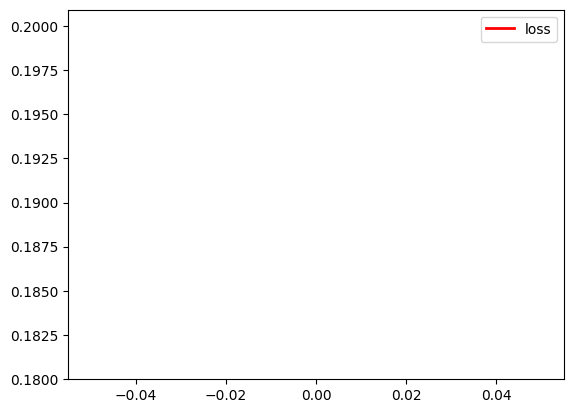

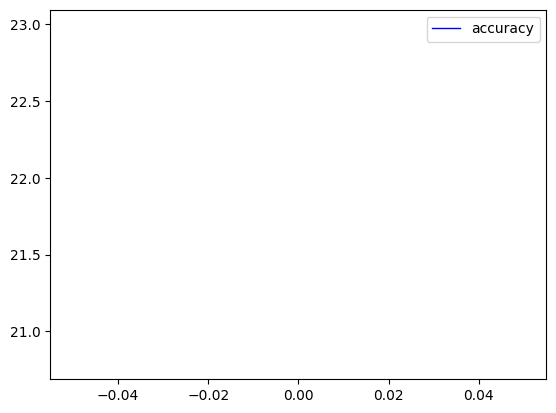

Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

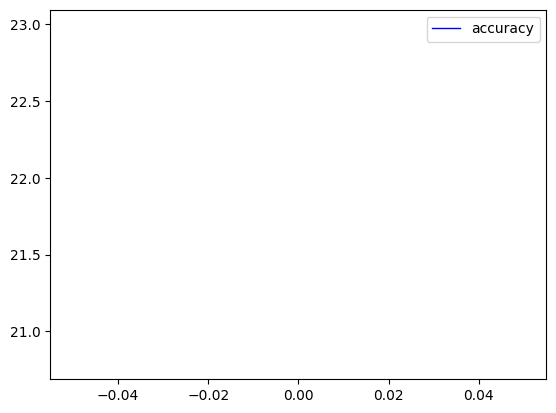

In [16]:
epochs = 1

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(X_train, y_train, model, loss_fn, optimizer))
    history['accuracies'].append(test(X_test, y_test, model, loss_fn))

    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")

In [33]:
engine = C4(gametype='learnset', torch_model=model, verbose=True)

Game Type       : learnset
Players         : Albert (-1), Paul (1)
Starting Player : ('Albert', 'SetAI')


In [34]:
engine.play_game()

Player: Albert, Moves Left: 42
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
0  1  2  3  4  5  6  

Player: Paul, Moves Left: 41
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  _  _  _  _  _  _  
_  O  _  _  _  _  _  
0  1  2  3  4  5  6  



RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x252 and 6x1)